In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

df = pd.read_csv("MMM_test_data.csv")
df.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000


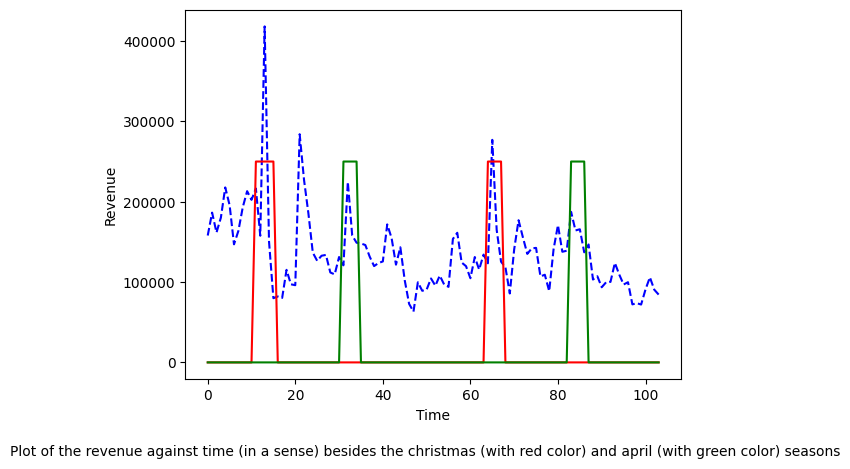

In [3]:
fig, ax = plt.subplots()

fig.text(.5, -0.05, "Plot of the revenue against time (in a sense) besides the christmas (with red color) and april (with green color) seasons", ha='center')
plt.xlabel("Time")
plt.ylabel("Revenue")

constant = np.ones(df.shape[0])
trend = np.arange(df.shape[0])
christmas = df["start_of_week"].str.contains(pat="[0-9]+-11-[0-9]+", regex=True).replace([True, False], [1, 0]).shift(periods=2, fill_value=0)
aprils = df["start_of_week"].str.contains(pat="[0-9]+-04-[0-9]+", regex=True).replace([True, False], [1, 0])

ax.plot(trend, df["revenue"].values, "b--", trend, christmas*250000, "r-", trend, aprils*250000, "g-")


It is clear that those two seasons have a substantial effect on revenue.
Therefore, we consider them in our model.

Besides, we can let the overall revenue have a trend that is independent of spendings as it continues to exist. This trend can be a negative or a positive one.
In addition, the company can have some (sort of) constant profit that is not effect by either of the factors.

Hence, a model containing those four control variables seems to be convincible.

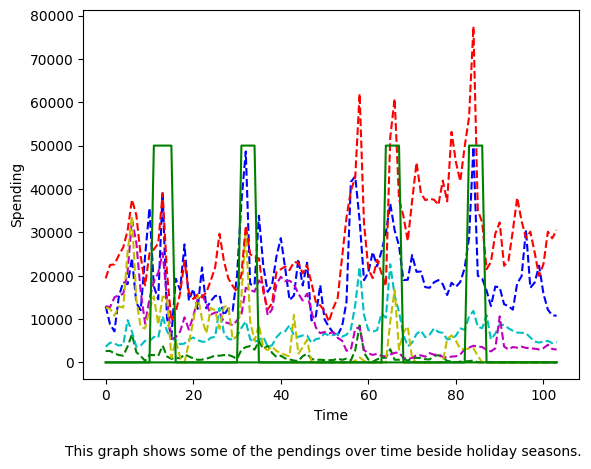

In [4]:
fig2, ax2 = plt.subplots()

fig2.text(.5, -0.05, "This graph shows some of the pendings over time beside holiday seasons.", ha='center')
plt.xlabel("Time")
plt.ylabel("Spending")

ax2.plot(trend, df["spend_channel_1"].values, "g--", trend, df["spend_channel_3"].values, "b--", trend, df["spend_channel_4"].values, "c--", trend, df["spend_channel_5"].values, "m--", trend, df["spend_channel_6"].values, "y--", trend, df["spend_channel_7"].values, "r--",  trend, christmas*50000, "g-", trend, aprils*50000, "g-")

On the Other hand, these control variables come with downsides too.
For example, the spending channel 1 and 5 have significant trends themselves. Therefore adding a trend to the model might undermine/overestimate the effects of these channels.

Further, channels 6 and 3 (and to some extent other channels too) have seasonal behavior obviously, i.e., they show significant increases in holiday seasons. Therefore, the seasonality control variables can affect our estimate of channel spending efficiency.

In [11]:
# This function calculates the adStock effect. Here, 
# L is length of carry-over effect (i.e., how long a spending affects the revenue),
# delay is the delay between the channel spending and its effect on revenue,
# alpha is the carry-over factor.
def adstock(x_t, alpha: float, delay=0, L: int=None):
    if not L:
        L = x_t.shape[0]
    if delay < 0 or delay >= L or L < 0:
        raise ValueError
    weights = [alpha**((i-delay)**2) for i in range(L)]
    weights /= pm.math.sum(weights)
    t_max = x_t.shape[0]
    stacked_x_t = pm.math.stack([pm.math.concatenate([np.zeros(i), x_t[:t_max-i]]) for i in range(L)])
    return pm.math.dot(weights, stacked_x_t)

with pm.Model() as model:
    contributions = []
    # Defining the model parameters
    # revenue[t] = beta_0 + sum(beta_m*spending_channel_m[t]) + Error[t] 
    sigma_error = pm.Exponential("sigma_error", lam=1e-3)

    # Control variables (constant, trend, christmas holidays, april vacations)
    gamma_constant = pm.Normal("gamma_constant", mu=1e5, sigma=1e5)
    contributions.append(gamma_constant*constant)

    gamma_trend = pm.Normal("gamma_trend", mu=0, sigma=1e4)
    contributions.append(gamma_trend*trend)
    
    gamma_christmas = pm.Normal("gamma_christmas", mu=2e5, sigma=2e5)
    contributions.append(gamma_christmas*christmas)

    gamma_april = pm.Normal("gamma_april", mu=1e5, sigma=1e5)
    contributions.append(gamma_april*aprils)

    # Spend channels
    for channel in df.columns.tolist()[2:]:
        beta = pm.HalfNormal(f"beta_{channel}", sigma=1e2)
        alpha = pm.Beta(f"alpha_{channel}", alpha=3, beta=3)
        contributions.append(beta*adstock(df[channel].values, alpha=alpha, L=4, delay=1))
    
    # Likelihood (observed data)
    likelihood = pm.Normal("revenue_obs", mu=pm.math.sum(contributions), sigma=sigma_error, observed=df["revenue"].values)

    # Sampling and Iterating
    trace = pm.sample(10000, tune=50000)

# Save the result
trace.to_netcdf("model.nc")

# Summarizing the results
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_error, gamma_constant, gamma_trend, gamma_christmas, gamma_april, beta_spend_channel_1, alpha_spend_channel_1, beta_spend_channel_2, alpha_spend_channel_2, beta_spend_channel_3, alpha_spend_channel_3, beta_spend_channel_4, alpha_spend_channel_4, beta_spend_channel_5, alpha_spend_channel_5, beta_spend_channel_6, alpha_spend_channel_6, beta_spend_channel_7, alpha_spend_channel_7]


Sampling 3 chains for 50_000 tune and 10_000 draw iterations (150_000 + 30_000 draws total) took 59684 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_constant,86.227,110097.567,-198710.643,214908.256,46648.444,34885.489,5.0,26.0,1.56
gamma_trend,-24519.105,5289.309,-35395.557,-15162.875,1929.144,1468.186,8.0,37.0,1.28
gamma_christmas,207906.605,189582.023,-125323.572,600059.425,51456.346,37196.881,13.0,33.0,1.17
gamma_april,82615.078,101023.684,-37276.353,281764.073,37853.394,27946.039,8.0,196.0,1.33
sigma_error,43062.832,2134.936,39057.810,47082.236,441.085,316.736,24.0,113.0,1.09
beta_spend_channel_1,55.794,39.560,1.150,130.378,3.739,2.651,77.0,37.0,1.04
alpha_spend_channel_1,0.490,0.186,0.147,0.816,0.019,0.014,94.0,145.0,1.04
beta_spend_channel_2,111.980,59.521,10.015,210.469,16.662,12.062,13.0,44.0,1.18
alpha_spend_channel_2,0.468,0.150,0.290,0.787,0.048,0.035,13.0,44.0,1.27
beta_spend_channel_3,11.171,7.290,1.627,24.316,2.179,1.583,11.0,44.0,1.20


array([[<AxesSubplot: title={'center': 'sigma_error'}>,
        <AxesSubplot: title={'center': 'sigma_error'}>]], dtype=object)

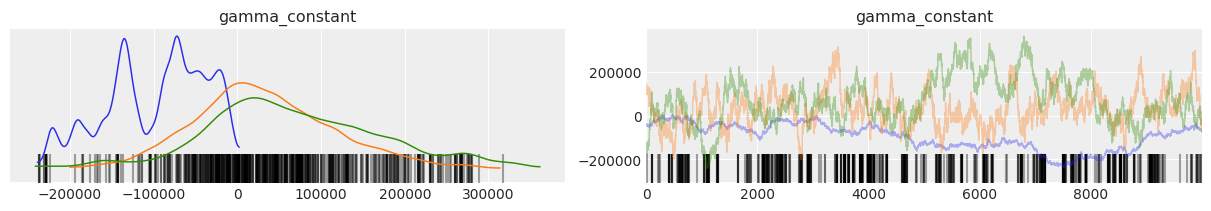

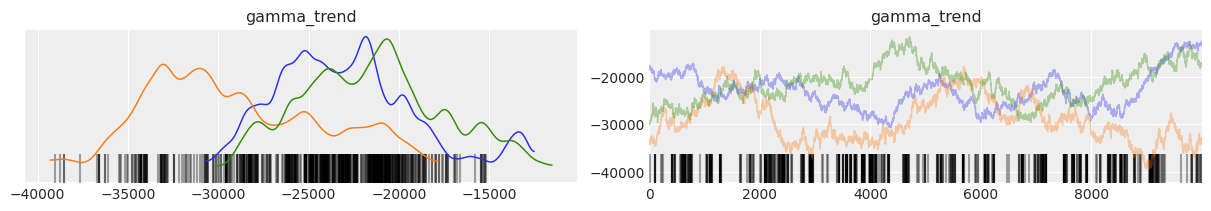

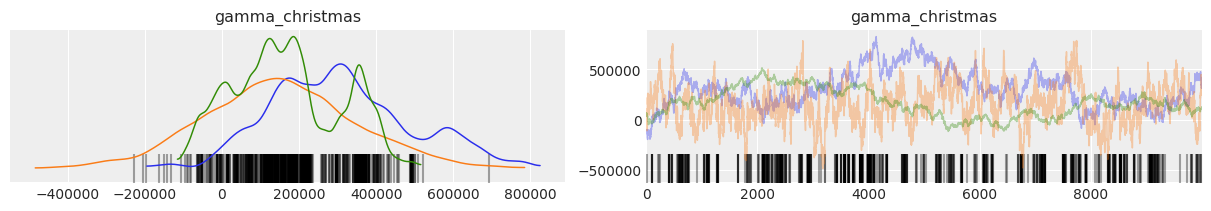

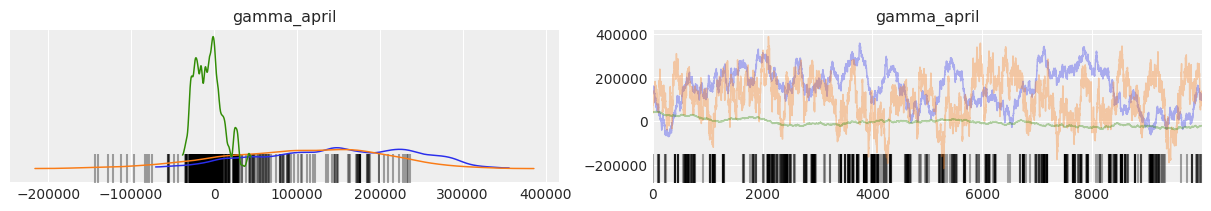

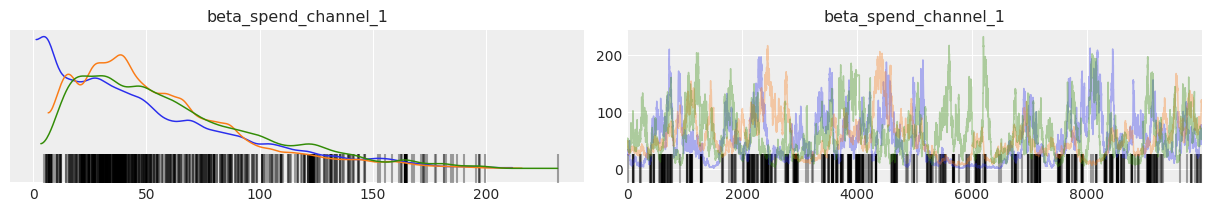

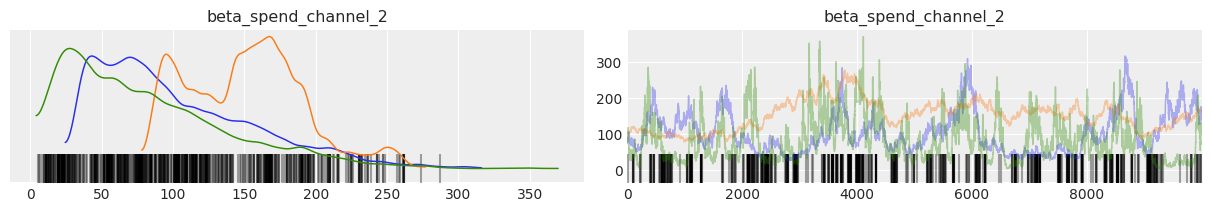

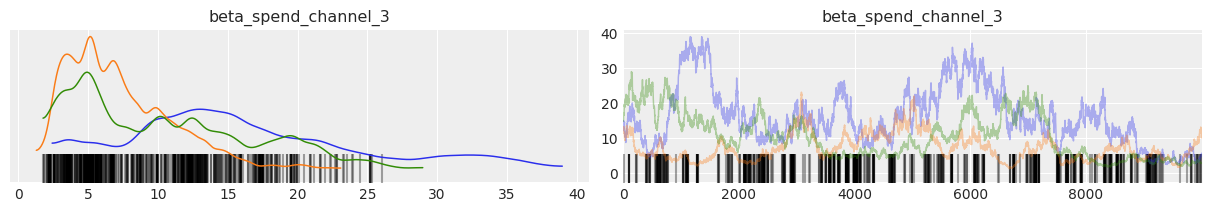

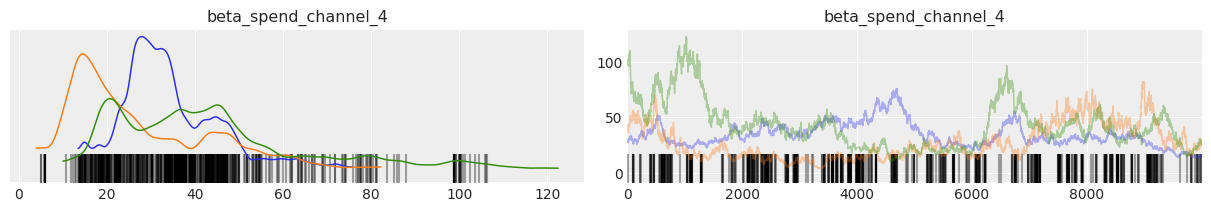

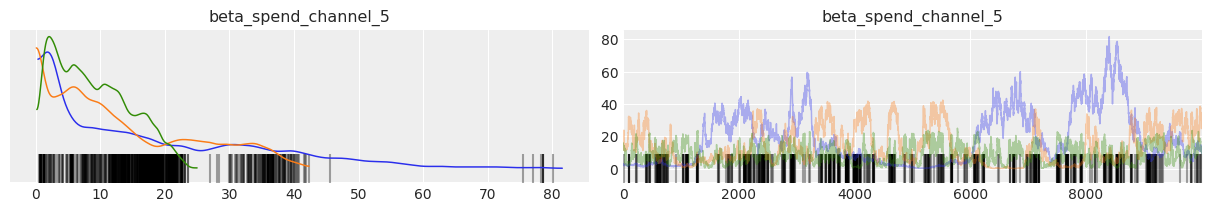

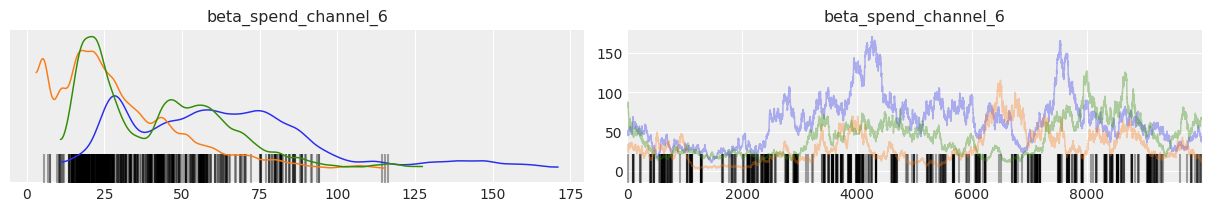

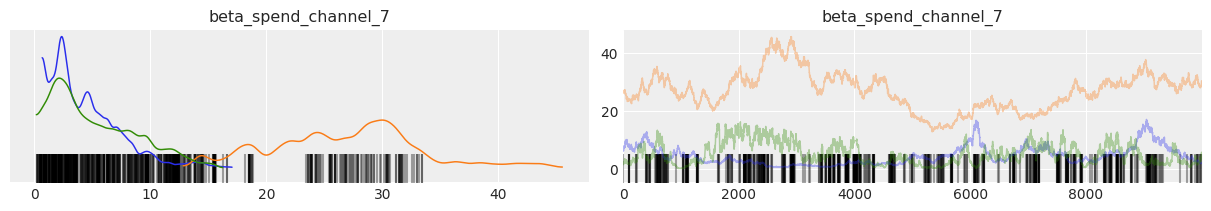

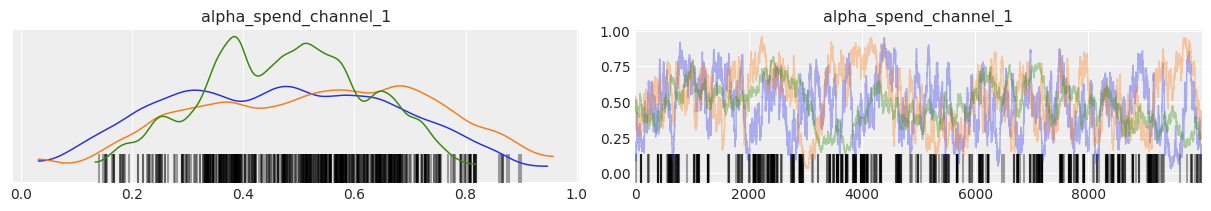

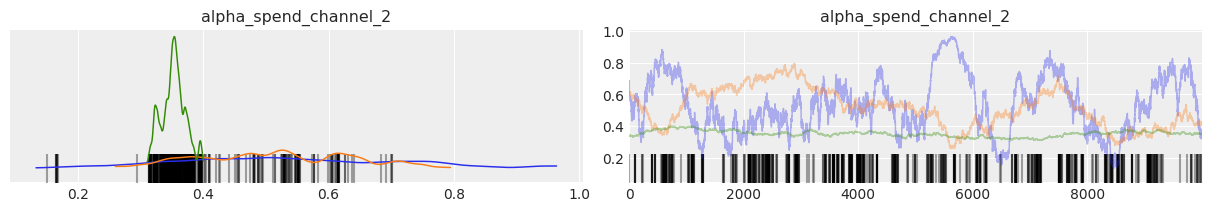

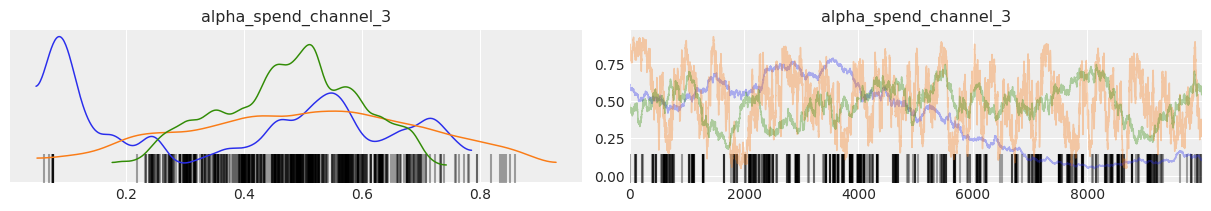

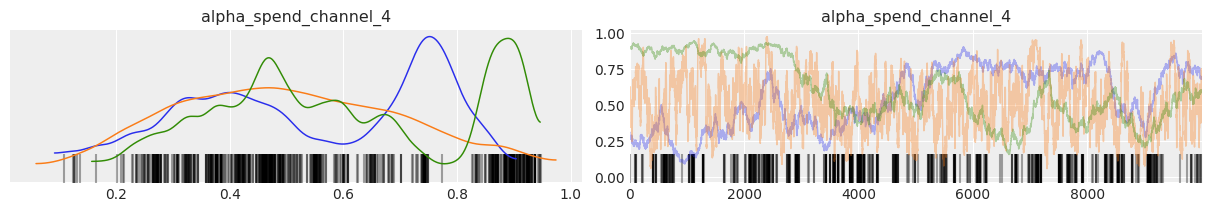

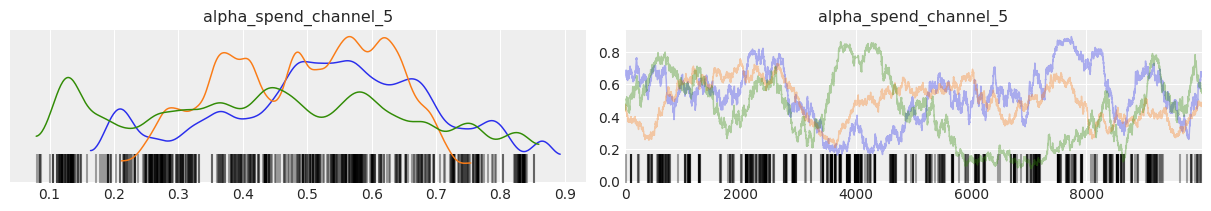

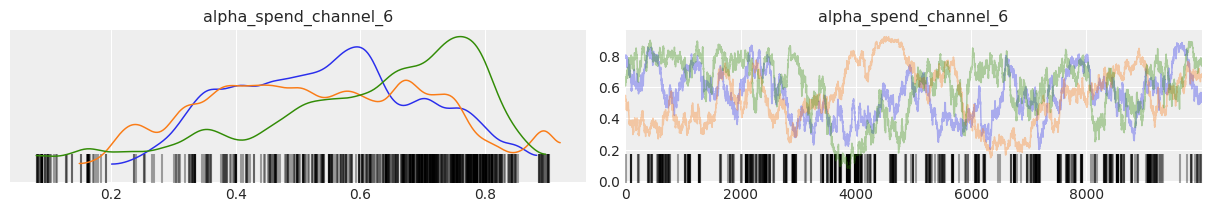

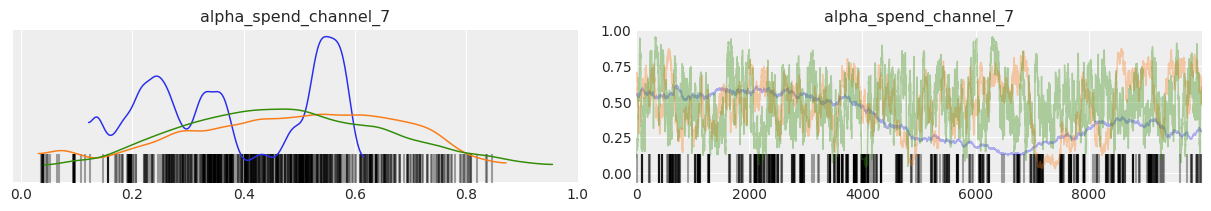

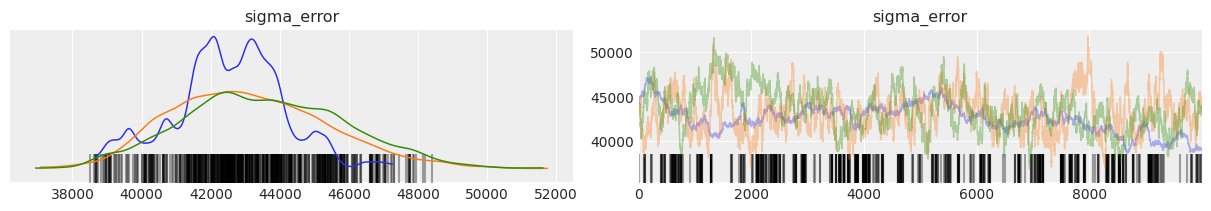

In [12]:
names_gamma = ["gamma_constant", "gamma_trend", "gamma_christmas", "gamma_april"]
names_beta = []
names_alpha = []
for channel in df.columns.tolist()[2:]:
     names_beta.append(f"beta_{channel}")
     names_alpha.append(f"alpha_{channel}")

az.style.use("arviz-darkgrid")
for p in sum([names_gamma, names_beta, names_alpha], []):
     az.plot_trace(trace, compact=False, var_names=[p], backend="matplotlib")


az.plot_trace(trace, compact=False, var_names=["sigma_error"], backend="matplotlib")